<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Автор материала: аналитик-разработчик в команде Яндекс.Метрики Мария Мансурова. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

#### <center>К [статье](https://habrahabr.ru/company/ods/blog/323730/) на Хабре "Предсказываем будущее с помощью библиотеки Facebook Prophet"

In [7]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd

from plotly import __version__
print(__version__) # need 1.9.0 or greater
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)
    
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

2.0.11


## Загрузка и предобработка данных
Данные [соревнования](https://inclass.kaggle.com/c/howpop-habrahabr-favs-lognorm) по прогнозу популярности статьи на Хабрахабре.

In [8]:
habr_df = pd.read_csv('../../data/howpop_train.csv')

In [9]:
habr_df['published'] = pd.to_datetime(habr_df.published)
habr_df = habr_df[['published', 'url']]
habr_df = habr_df.drop_duplicates()

In [10]:
aggr_habr_df = habr_df.groupby('published')[['url']].count()
aggr_habr_df.columns = ['posts']

In [11]:
aggr_habr_df = aggr_habr_df.resample('D').apply(sum)
plotly_df(aggr_habr_df.resample('W').apply(sum), 
          title = 'Опубликованные посты на Хабрахабре')

## Построение прогноза Prophet

In [12]:
# pip install pystan
# pip install fbprophet
from fbprophet import Prophet

In [13]:
predictions = 30

df = aggr_habr_df.reset_index()
df.columns = ['ds', 'y']
df.tail()

,ds,y
3222,2016-10-27,58.0
3223,2016-10-28,53.0
3224,2016-10-29,14.0
3225,2016-10-30,27.0
3226,2016-10-31,80.0


In [14]:
train_df = df[:-predictions]

In [15]:
m = Prophet()
m.fit(train_df)

In [16]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
3222,2016-10-27
3223,2016-10-28
3224,2016-10-29
3225,2016-10-30
3226,2016-10-31


In [17]:
forecast = m.predict(future)
forecast.tail()

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat
3222,2016-10-27,1.008135,56.642185,10.715326,10.715326,56.642185,56.642185,54.837421,81.810483,8.475115,8.475115,8.475115,2.240211,2.240211,2.240211,10.715326,67.357512
3223,2016-10-28,1.008448,56.638330,6.915659,6.915659,56.638330,56.638330,49.405394,76.773647,4.654308,4.654308,4.654308,2.261351,2.261351,2.261351,6.915659,63.553988
3224,2016-10-29,1.008761,56.634474,-21.062624,-21.062624,56.634472,56.635111,22.036734,50.817168,-23.329135,-23.329135,-23.329135,2.266511,2.266511,2.266511,-21.062624,35.571850
3225,2016-10-30,1.009074,56.630618,-18.640583,-18.640583,56.629693,56.631936,23.827778,52.942018,-20.896833,-20.896833,-20.896833,2.256250,2.256250,2.256250,-18.640583,37.990035
3226,2016-10-31,1.009387,56.626762,11.819400,11.819400,56.623456,56.629654,53.710864,83.400649,9.587923,9.587923,9.587923,2.231477,2.231477,2.231477,11.819400,68.446162


In [18]:
print(', '.join(forecast.columns))

ds, t, trend, seasonal_lower, seasonal_upper, trend_lower, trend_upper, yhat_lower, yhat_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, seasonal, yhat


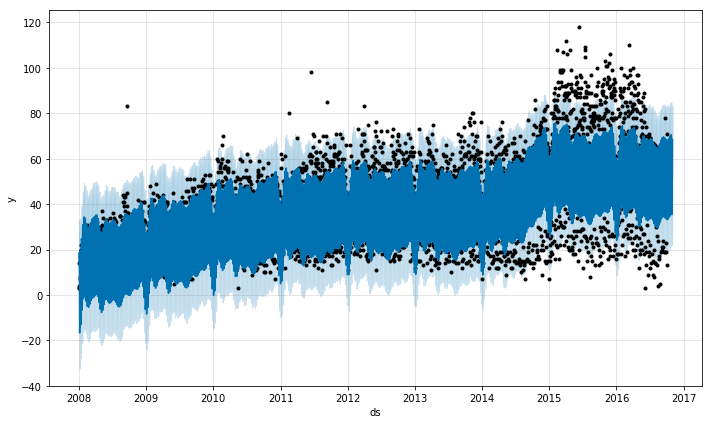

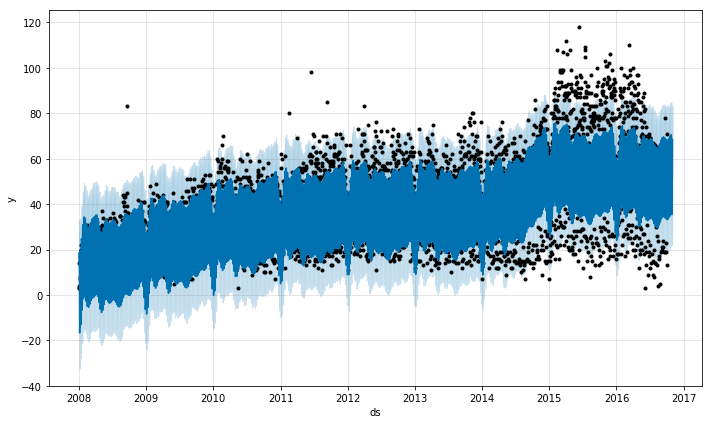

In [19]:
m.plot(forecast)

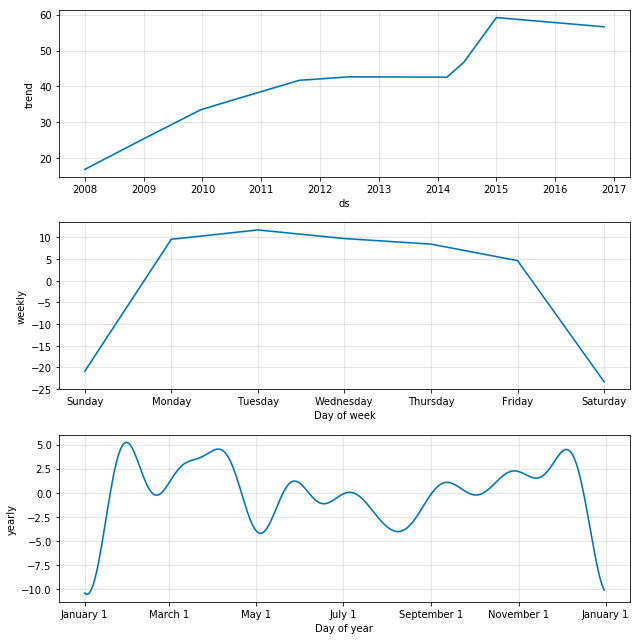

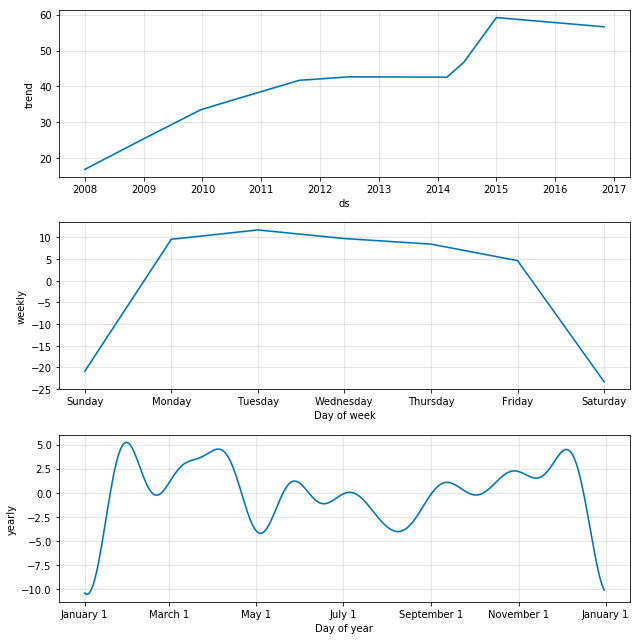

In [20]:
m.plot_components(forecast)

## Оценка качества Prophet

In [21]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [22]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
np.mean(abs(cmp_df[-predictions:]['p'])), np.mean(abs(cmp_df[-predictions:]['e']))

(37.403970334988358, 10.640571661695112)

## Прогноз с BoxCox

In [23]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

In [24]:
train_df2 = train_df.copy().fillna(14)
train_df2 = train_df2.set_index('ds')
train_df2['y'], lmbda_prophet = stats.boxcox(train_df2['y'])

train_df2.reset_index(inplace=True)

m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=30)

forecast2 = m2.predict(future2)
forecast2['yhat'] = invboxcox(forecast2.yhat, lmbda_prophet)
forecast2['yhat_lower'] = invboxcox(forecast2.yhat_lower, lmbda_prophet)
forecast2['yhat_upper'] = invboxcox(forecast2.yhat_upper, lmbda_prophet)

cmp_df2 = forecast2.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

cmp_df2['e'] = cmp_df2['y'] - cmp_df2['yhat']
cmp_df2['p'] = 100*cmp_df2['e']/cmp_df2['y']
np.mean(abs(cmp_df2[-predictions:]['p'])), np.mean(abs(cmp_df2[-predictions:]['e']))

(26.900159755041948, 8.5191877423084161)

## Визуализация результатов

In [25]:
def show_forecast(cmp_df, num_predictions, num_values):
    upper_bound = go.Scatter(
        name='Upper Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_upper,
        mode='lines',
        marker=dict(color="444"),
        line=dict(width=0),
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty')

    forecast = go.Scatter(
        name='Prediction',
        x=cmp_df.tail(predictions).index,
        y=cmp_df.tail(predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )

    lower_bound = go.Scatter(
        name='Lower Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_lower,
        marker=dict(color="444"),
        line=dict(width=0),
        mode='lines')

    fact = go.Scatter(
        name='Fact',
        x=cmp_df.tail(num_values).index,
        y=cmp_df.tail(num_values).y,
        marker=dict(color="red"),
        mode='lines',
    )

    # Trace order can be important
    # with continuous error bars
    data = [lower_bound, upper_bound, forecast, fact]

    layout = go.Layout(
        yaxis=dict(title='Посты'),
        title='Опубликованные посты на Хабрахабре',
        showlegend = False)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

In [26]:
show_forecast(cmp_df, predictions, 200)

##  Сравнение с ARIMA моделью

In [27]:
train_df = train_df.fillna(14).set_index('ds')

Критерий Дики-Фуллера: p=0.040528


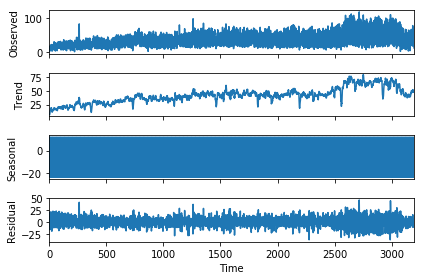

In [28]:
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(train_df['y'].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

In [29]:
train_df.index = pd.to_datetime(train_df.index)

Оптимальный параметр преобразования Бокса-Кокса: 0.415948
Критерий Дики-Фуллера: p=0.040528


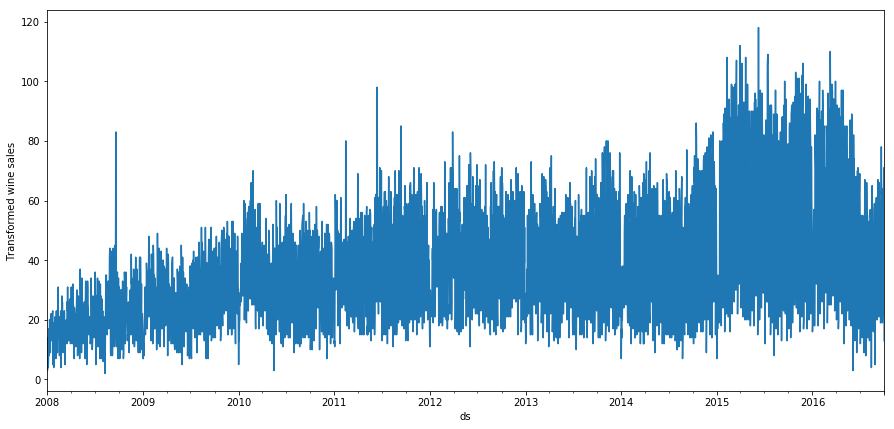

In [30]:
train_df['y_box'], lmbda = stats.boxcox([1 if x == 0 else x for x in train_df['y']])
plt.figure(figsize=(15,7))
train_df.y.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

Критерий Дики-Фуллера: p=0.000000


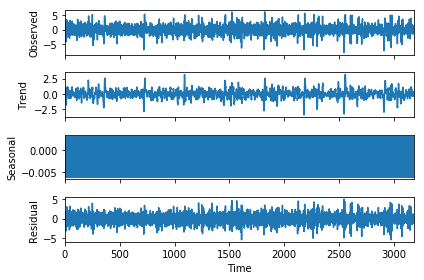

In [31]:
train_df['y_box_diff'] = train_df.y_box - train_df.y_box.shift(7)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(train_df.y_box_diff[12:].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df.y_box_diff[8:])[1])

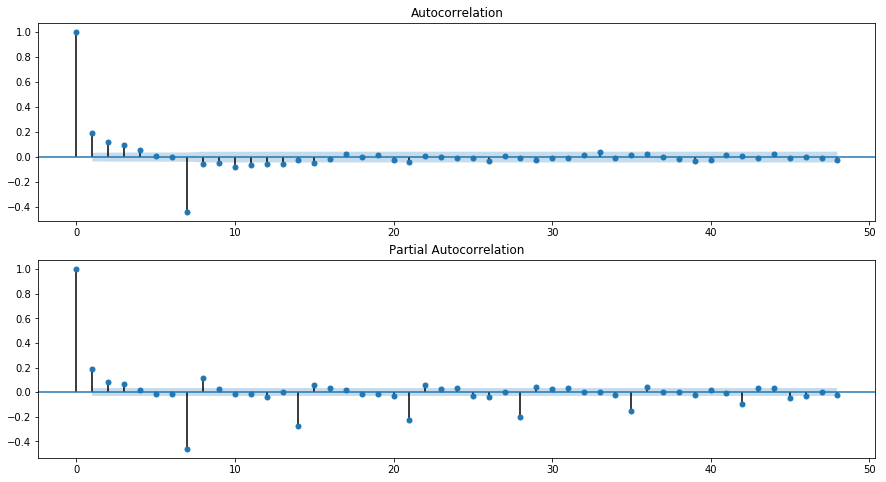

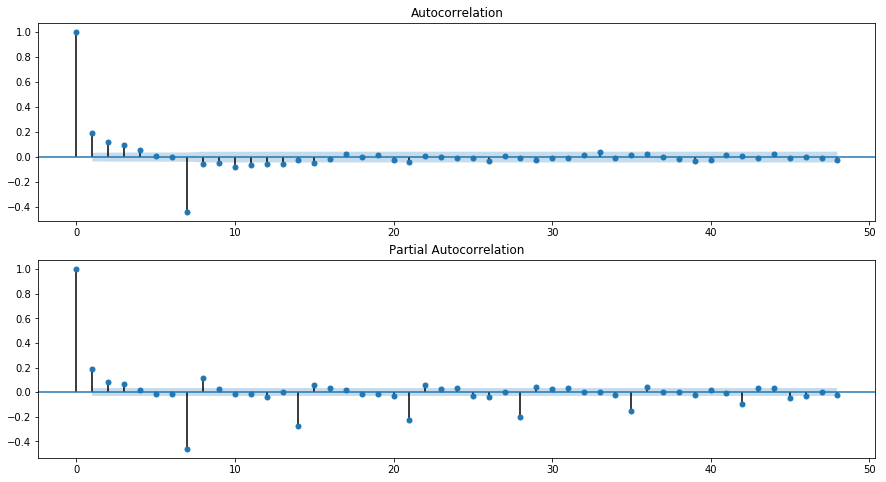

In [32]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_box_diff[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.y_box_diff[13:].values.squeeze(), lags=48, ax=ax)

Начальные приближения Q = 1, q = 4, P = 5, p = 3

In [33]:
ps = range(0, 4)
d=1
qs = range(0, 5)
Ps = range(0, 7)
D=1
Qs = range(0, 2)

In [34]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

280

In [37]:
%%time
results = []
best_aic = float("inf")



for param in parameters_list:
    print(param)
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train_df.y_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

(0, 0, 0, 0)
wrong parameters: (0, 0, 0, 0)
(0, 0, 0, 1)
(0, 0, 1, 0)
(0, 0, 1, 1)
(0, 0, 2, 0)
(0, 0, 2, 1)
(0, 0, 3, 0)
(0, 0, 3, 1)
(0, 0, 4, 0)
(0, 0, 4, 1)
(0, 0, 5, 0)
(0, 0, 5, 1)
(0, 0, 6, 0)
(0, 0, 6, 1)
(0, 1, 0, 0)
(0, 1, 0, 1)
(0, 1, 1, 0)
(0, 1, 1, 1)
(0, 1, 2, 0)
(0, 1, 2, 1)
(0, 1, 3, 0)
(0, 1, 3, 1)
(0, 1, 4, 0)
(0, 1, 4, 1)
(0, 1, 5, 0)
(0, 1, 5, 1)
(0, 1, 6, 0)
(0, 1, 6, 1)
(0, 2, 0, 0)
(0, 2, 0, 1)
(0, 2, 1, 0)
(0, 2, 1, 1)
(0, 2, 2, 0)
(0, 2, 2, 1)
(0, 2, 3, 0)
(0, 2, 3, 1)
(0, 2, 4, 0)
(0, 2, 4, 1)
(0, 2, 5, 0)
(0, 2, 5, 1)
(0, 2, 6, 0)
(0, 2, 6, 1)
(0, 3, 0, 0)
(0, 3, 0, 1)
(0, 3, 1, 0)
(0, 3, 1, 1)
(0, 3, 2, 0)
(0, 3, 2, 1)
(0, 3, 3, 0)
(0, 3, 3, 1)
(0, 3, 4, 0)
(0, 3, 4, 1)
(0, 3, 5, 0)
(0, 3, 5, 1)
(0, 3, 6, 0)
(0, 3, 6, 1)
(0, 4, 0, 0)
(0, 4, 0, 1)
(0, 4, 1, 0)
(0, 4, 1, 1)
(0, 4, 2, 0)
(0, 4, 2, 1)
(0, 4, 3, 0)
(0, 4, 3, 1)
(0, 4, 4, 0)
(0, 4, 4, 1)
(0, 4, 5, 0)
(0, 4, 5, 1)
(0, 4, 6, 0)
(0, 4, 6, 1)
(1, 0, 0, 0)
(1, 0, 0, 1)
(1, 0, 1, 0)
(1, 0, 1, 1)
(1, 0, 

LinAlgError: Singular matrix

In [38]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters          aic
142  (2, 3, 1, 1)  9613.765120
140  (2, 3, 0, 1)  9623.172033
128  (2, 1, 1, 1)  9627.841911
132  (2, 1, 3, 1)  9628.014058
130  (2, 1, 2, 1)  9629.034730


In [39]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             y_box   No. Observations:                 3197
Model:             SARIMAX(2, 1, 3)x(1, 1, 1, 7)   Log Likelihood               -4798.883
Date:                           Fri, 30 Jun 2017   AIC                           9613.765
Time:                                   10:29:14   BIC                           9662.325
Sample:                               01-01-2008   HQIC                          9631.176
                                    - 10-01-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0880      2.352     -0.037      0.970      -4.697       4.521
ar.L2          0.5042      1.551      0.325

Критерий Стьюдента: p=0.106120
Критерий Дики-Фуллера: p=0.000000


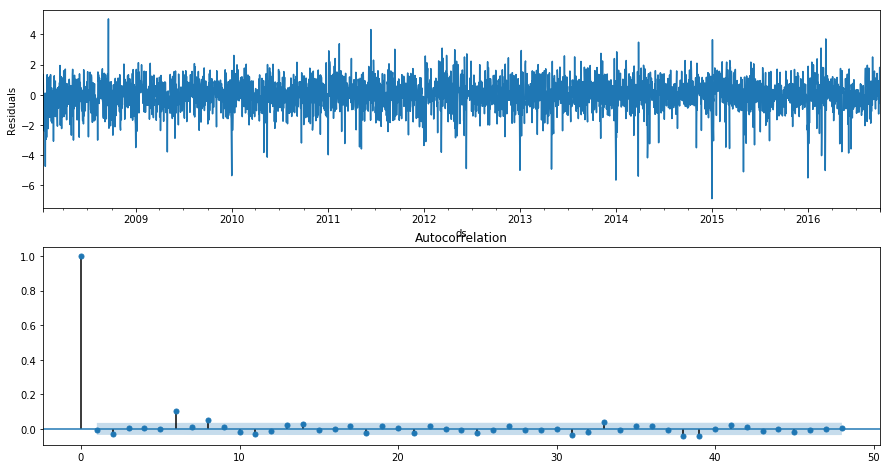

In [40]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

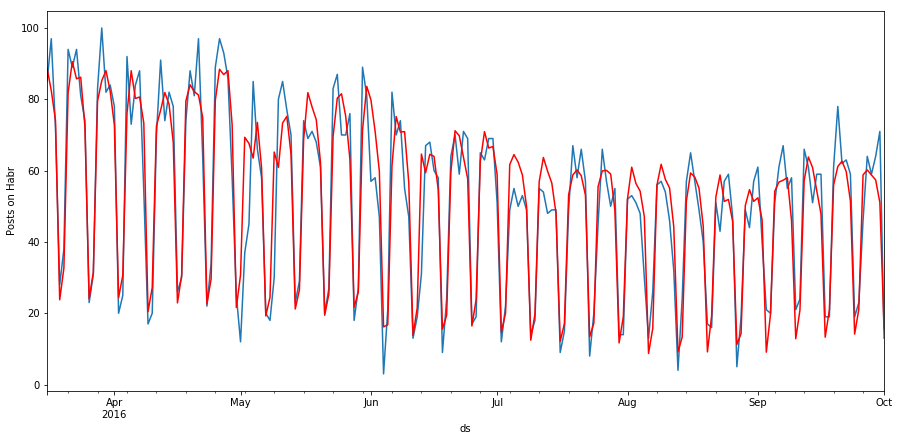

In [41]:
train_df['arima_model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
train_df.y.tail(200).plot()
train_df.arima_model[13:].tail(200).plot(color='r')
plt.ylabel('Posts on Habr');

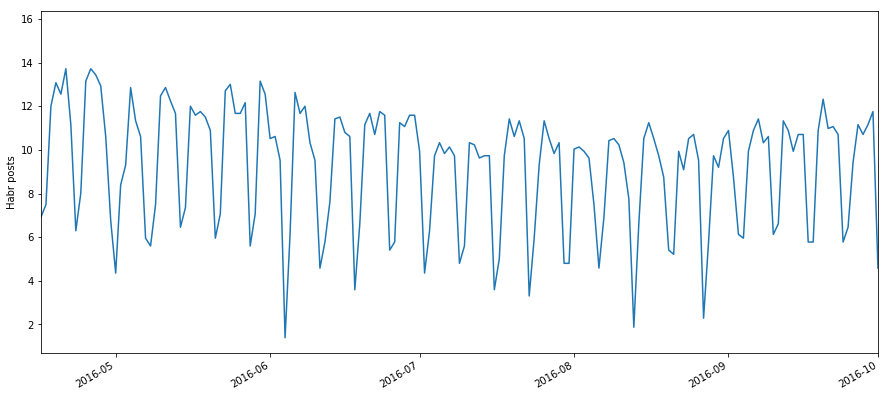

In [47]:
arima_df = train_df2.set_index('ds')[['y']]

date_list = [pd.datetime.strptime("2016-10-01", "%Y-%m-%d") + 
             pd.Timedelta(x) for x in range(0, predictions+1)]
future = pd.DataFrame(index=date_list, columns= arima_df.columns)
arima_df = pd.concat([arima_df, future])
arima_df['forecast'] = invboxcox(best_model.predict(start=train_df.shape[0]-1, end=train_df.shape[0]+predictions-1), lmbda)
plt.figure(figsize=(15,7))
arima_df.y.tail(200).plot()
arima_df.forecast.tail(200).plot(color='r')
plt.ylabel('Habr posts');

In [43]:
cmp_df.head()

,yhat,yhat_lower,yhat_upper,y,e,p
ds,,,,,,
2008-01-01,18.410414,4.571551,33.303234,3.0,-15.410414,-513.680450
2008-01-02,16.253245,1.229630,29.935755,3.0,-13.253245,-441.774842
2008-01-03,14.898599,0.643315,28.811782,4.0,-10.898599,-272.464976
2008-01-04,11.116994,-3.164607,25.555793,14.0,2.883006,20.592900
2008-01-05,-16.719572,-32.440108,-2.093498,4.0,20.719572,517.989294


In [44]:
cmp_df = cmp_df.join(arima_df[['forecast']])

In [48]:
import numpy as np
cmp_df['e_arima'] = cmp_df['y'] - cmp_df['forecast']
cmp_df['p_arima'] = 100*cmp_df['e_arima']/cmp_df['y']
np.mean(abs(cmp_df2[-predictions:]['p'])), np.mean(abs(cmp_df2[-predictions:]['e']))

(26.900159755041948, 8.5191877423084161)

In [49]:
np.mean(abs(cmp_df[-predictions:]['p'])), np.mean(abs(cmp_df[-predictions:]['e']))

(37.403970334988358, 10.640571661695112)

In [46]:
num_values = 200

forecast = go.Scatter(
    name='Prophet',
    x=cmp_df.tail(predictions).index,
    y=cmp_df.tail(predictions).yhat,
    mode='lines',
    line=dict(color='rgb(31, 119, 180)'),
)


fact = go.Scatter(
    name='Fact',
    x=cmp_df.tail(num_values).index,
    y=cmp_df.tail(num_values).y,
    marker=dict(color="red"),
    mode='lines',
)

arima = go.Scatter(
    name='ARIMA',
    x=cmp_df.tail(predictions).index,
    y=cmp_df.tail(predictions).forecast,
    mode='lines'
)

# Trace order can be important
# with continuous error bars
data = [forecast, fact, arima]

layout = go.Layout(
    yaxis=dict(title='Посты'),
    title='Опубликованные посты на Хабрахабре',
    showlegend = True)

fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)